In [1]:
#This cell is to preprocess the data
import pandas as pd
from collections import Counter
# from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold,train_test_split
from sklearn.metrics import average_precision_score,recall_score
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import numpy as np


#extract the data
raw_df = pd.read_csv("~/ML_class_projects/a_1/BitcoinHeistData.csv")
cleaned_df = raw_df.copy()

#clean the data
cleaned_df['class']=np.array([0 if x=='white' else 1 for x in cleaned_df.pop('label')])
cleaned_df.pop("address")
cleaned_df.pop("year")
cleaned_df.pop("day")
print(cleaned_df.head(5))

#summarize data distribution
y=np.array(cleaned_df['class'])
X=np.array(cleaned_df.iloc[:,:-1])
print(Counter(y))


#define the undersampling method
under = RandomUnderSampler(sampling_strategy=0.5)


   length    weight  count  looped  neighbors       income  class
0      18  0.008333      1       0          2  100050000.0      1
1      44  0.000244      1       0          1  100000000.0      1
2       0  1.000000      1       0          2  200000000.0      1
3      72  0.003906      1       0          2   71200000.0      1
4     144  0.072848    456       0          1  200000000.0      1
Counter({0: 2875284, 1: 41413})


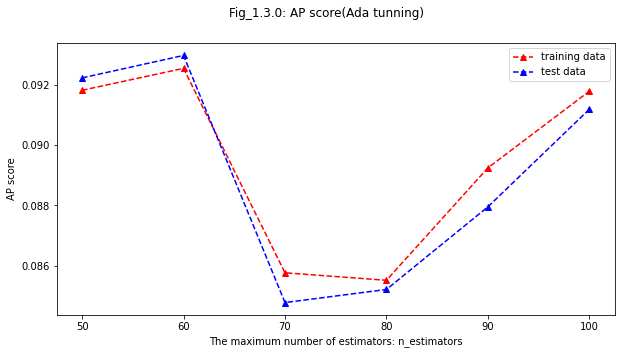

In [2]:

########corss-validation to find the number of max_estimators##################
t=7
cv = KFold(n_splits=t,shuffle=True)
AP_train_score_list=[]
AP_test_score_list=[]
n_estimators_range=range(50,101,10)
for n_estimator in n_estimators_range:
    #define pipline
    clf = tree.DecisionTreeClassifier(min_impurity_decrease=1e-3)
    abc =AdaBoostClassifier(n_estimators=n_estimator, base_estimator=clf,learning_rate=1)
    steps = [('under',under),('model',abc)]
    pipeline = Pipeline(steps=steps)
    scores =  cross_validate(pipeline, X, y, scoring=['recall','average_precision'], cv=cv, n_jobs=-1,return_train_score=True)
#     recall_train_score_list.append(sum(scores['train_recall'])/t)
#     recall_test_score_list.append(sum(scores['test_recall'])/t)
    
    AP_train_score_list.append(sum(scores['train_average_precision'])/t)
    AP_test_score_list.append(sum(scores['test_average_precision'])/t)
#     fit_time_list.append(sum(scores['fit_time'])/t)




# #generate Fig_1.3.0 tunning curves
m = len(n_estimators_range)
fig_0, axs = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
axs.plot(n_estimators_range,AP_train_score_list,"r^",linestyle = "--",label='training data')
axs.plot(n_estimators_range,AP_test_score_list,"b^",linestyle = "--",label='test data')
axs.set_xlabel("The maximum number of estimators: n_estimators")
axs.set_ylabel("AP score")
axs.legend()
fig_0.suptitle("Fig_1.3.0: AP score(Ada tunning)")
fig_0.savefig("Ada_fig_1.3_tunning:AP score.png")



# fig_1, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# axs[0].plot(n_estimators_range[:m],recall_train_score_list[:m],"r^",linestyle = "--", label='training data')
# axs[0].plot(n_estimators_range[:m],recall_test_score_list[:m],"b^",linestyle = "--",label='test data')
# axs[0].set_xlabel('The maximum number of estimators: n_estimators')
# axs[0].set_ylabel('Recall_score')
# axs[1].plot(n_estimators_range[:m],AP_train_score_list[:m],"r^",linestyle = "--",label='training data')
# axs[1].plot(n_estimators_range[:m],AP_test_score_list[:m],"b^",linestyle = "--",label='test data')
# axs[1].set_xlabel('The maximum number of estimators: n_estimators')
# axs[1].set_ylabel('AP_score')
# fig_1.suptitle('Fig_1.3.1:Recall_score,AP_score(Ada Boosting)')

# axs[0].legend()
# axs[1].legend()
# fig_1.savefig("Ada_fig_1.3:scores.png")


    
    
    


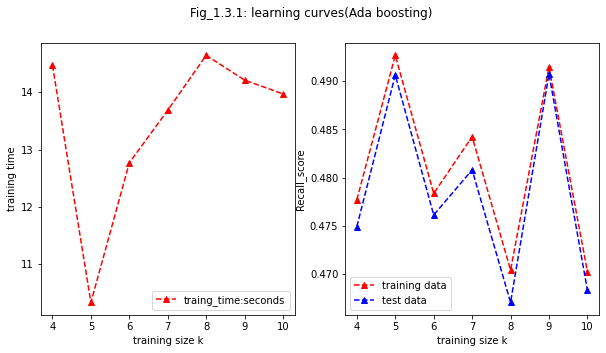

In [7]:
#########This cell is to train the model with n_estimators=60########

Recall_train_score=[]
Recall_test_score=[]
# AP_train_score=[]
# AP_test_score=[]
training_time = []

for k in range(4,11):
    cv = KFold(n_splits=k,shuffle=True)
    clf = tree.DecisionTreeClassifier(min_impurity_decrease=1e-3)
    abc =AdaBoostClassifier(n_estimators=60, base_estimator=clf,learning_rate=1)
    steps = [('under',under),('model',abc)]
    pipeline = Pipeline(steps=steps)
    scores =  cross_validate(pipeline, X, y, scoring=['recall','average_precision'], cv=cv, n_jobs=-1,return_train_score=True)
    Recall_train_score.append(sum(scores['train_recall'])/k)
    Recall_test_score.append(sum(scores['test_recall'])/k)
    
#     AP_train_score.append(sum(scores['train_average_precision'])/k)
#     AP_test_score.append(sum(scores['test_average_precision'])/k)
    training_time.append(sum(scores['fit_time'])/k)
    
K= range(4,11)
fig_1, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
axs[0].plot(K,training_time,"r^",linestyle = "--",label="traing_time:seconds")
axs[0].set_xlabel("training size k")
axs[0].set_ylabel("training time")
axs[1].plot(K,Recall_train_score,"r^",linestyle = "--",label='training data')
axs[1].plot(K,Recall_test_score,"b^",linestyle = "--",label='test data')
axs[1].set_xlabel("training size k")
axs[1].set_ylabel("Recall_score")
axs[0].legend()
axs[1].legend()
fig_1.suptitle("Fig_1.3.1: learning curves(Ada boosting)")

fig_1.savefig("Ada_fig_1.3_traninig:learning curves.png")



In [9]:
############This cell is to compare decision tree without and with boosting: generate the data in table1.3.0 in the write up##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/9, random_state=42)
X_train_under,y_train_under = under.fit_resample(X_train,y_train)
clf = tree.DecisionTreeClassifier(min_impurity_decrease=1e-03)
clf.fit(X_train_under,y_train_under)
print("base decision estimator's tree depth is:",clf.get_depth())
print("recall and AP scores for training data before boosting are:",recall_score(y_train,clf.predict(X_train)),average_precision_score(y_train,clf.predict_proba(X_train)[:,1]))
print("recall and AP scores for test data before boosting are:",recall_score(y_test,clf.predict(X_test)),average_precision_score(y_test,clf.predict_proba(X_test)[:,1]))


clf = tree.DecisionTreeClassifier(min_impurity_decrease=1e-03)
abc =AdaBoostClassifier(n_estimators=60, base_estimator=clf,learning_rate=1)
abc.fit(X_train_under,y_train_under)

print("recall and AP for training data after boosting are:",recall_score(y_train,abc.predict(X_train)),average_precision_score(y_train,abc.predict_proba(X_train)[:,1]))
print("recall and AP for test data after boosting are:",recall_score(y_test,abc.predict(X_test)),average_precision_score(y_test,abc.predict_proba(X_test)[:,1]))


base decision estimator's tree depth is: 11
recall and AP scores for training data before boosting are: 0.46262620779502767 0.08997009660035922
recall and AP scores for test data before boosting are: 0.45502298095863425 0.08740169390858595
recall and AP for training data after boosting are: 0.5162848767777657 0.09639751683699808
recall and AP for test data after boosting are: 0.5009848982271832 0.09298434487102802
